In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from typing import List, Tuple

from astropy.visualization import make_lupton_rgb

def gen_color_plot(pygalfit: object, band_combinations):
    pass

In [5]:
from pygalfitm.read import read_output_to_class

In [7]:
pyg = read_output_to_class("../outputs/iDR4_FORNAX_RUN1_SPLUS-s27s34.13511/iDR4_FORNAX_RUN1_SPLUS-s27s34.13511ss.galfit.01.band")

In [56]:
def get_bands(bands):
        r, g, b = bands.split(",")
        r = r.strip().lower().replace("f", "j0")
        g = g.strip().lower().replace("f", "j0")
        b = b.strip().lower().replace("f", "j0")
        return r, g, b

In [82]:
from matplotlib import pyplot as plt
from astropy.visualization import make_lupton_rgb

def gen_color_plot(pygalfit, band_combinations=["i,r,g", "u,f378,f395"], lupton_stretch=3.5, lupton_Q=8, return_plot=False, fig_filename=None):
    filters = pygalfit.base['A1']['value'].split(",") 
    for key, band in enumerate(filters): 
        filters[key] = band.strip()

    fits_cube = fits.open(pygalfit.base["B"]["value"].strip())

    # Get data for each filter
    input_data = {f: fits_cube[i + 1].data for i, f in enumerate(filters)}
    model_data = {f: fits_cube[i + len(filters) + 1].data for i, f in enumerate(filters)}
    residual_data = {f: fits_cube[i + 2*len(filters) + 1].data for i, f in enumerate(filters)}

    n_rows = len(band_combinations)
    n_columns = 3

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(n_columns*5, n_rows*5))

    for i, bands in enumerate(band_combinations):
        r, g, b = get_bands(bands)

        # Create RGB images
        rgb_images = [make_lupton_rgb(data[r], data[g], data[b], stretch=lupton_stretch, Q=lupton_Q) 
                      for data in (input_data, model_data, residual_data)]

        # Display images
        for j in range(n_columns):
            axs[i, j].imshow(rgb_images[j])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])

    # Label rows and columns
    for j in range(n_columns):
        axs[0, j].set_title(['Input', 'Model', 'Residual'][j], size='large')

    for i in range(n_rows):
        axs[i, 0].set_ylabel(band_combinations[i], size='large')

    # Adjust spacing between subplots and set background color
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.set_facecolor('white')

    if fig_filename and not return_plot:
        fig.savefig(fig_filename)
        return 
    
    elif fig_filename and return_plot:
        fig.savefig(fig_filename)

    if return_plot:
        return fig
    else:
        plt.show()


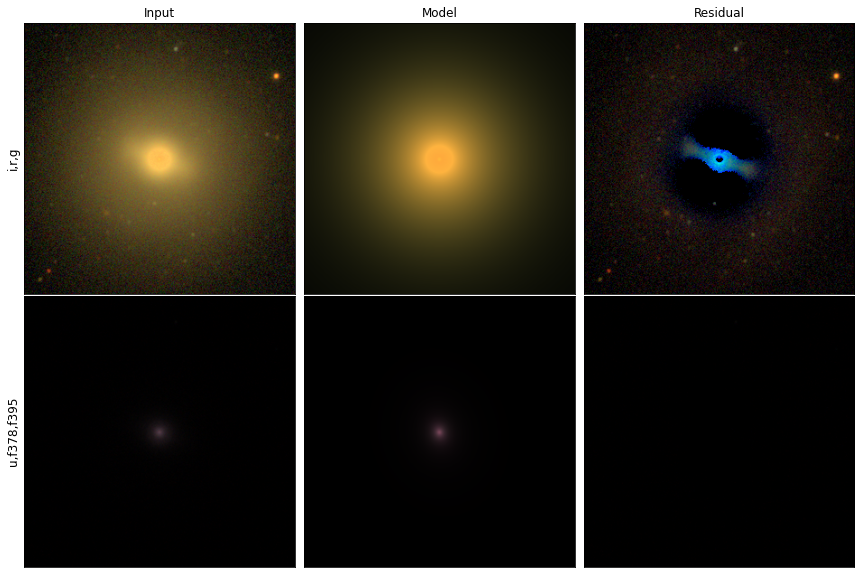

In [83]:
gen_color_plot(pyg)

In [10]:
def gen_plot(pygalfit: object, component_selected: str = "sersic", plot_parameters: List[str] = [],
             plotsize_factor: Tuple[float, float] = (1, 1), colorbar: bool = True, lupton_stretch: float = 0.2, 
             lupton_q: int = 8, fig_filename: str = None, return_plot: bool = False):
    
    """
        Generate a plot to visualize the input, model, and residual data of a PyGalfit model.
        
        Parameters:
            - pygalfit (object): the PyGalfit model object, which contains the input and output data from the PyGalfit fitting.
            - component_selected (str): the name of the PyGalfit component to plot (default is "sersic").
            - plot_parameters (List[str]): a list of parameters to plot for the selected component (default is an empty list).
            - plotsize_factor (Tuple[float, float]): a tuple specifying the size of the plot, default is (1,1).
            - colorbar (bool): a boolean indicating whether to show the color bar on the plot (default is True).
            - lupton_stretch (float): a float specifying the stretch factor used for the Lupton RGB image (default is 0.2).
            - lupton_q (int): an integer specifying the Q factor used for the Lupton RGB image (default is 8).
            - fig_filename (str): a string specifying the filename to save the plot to (default is None).
            - return_plot (bool): a boolean indicating whether to return the plot object instead of showing it (default is False).
            
        Returns:
            - fig (plt.Figure): the matplotlib Figure object, only if `return_plot` is True.
    """

    filters = pygalfit.base['A1']['value'].split(",") 
    for key, band in enumerate(filters): 
        filters[key] = band.strip()
    
    fits_cube = fits.open(pygalfit.base["B"]["value"].strip())

    plot_data = {}
    for band in filters:
        plot_data[band] = []

    
    for key, param in enumerate(plot_parameters):

        values = pygalfit.components_config[component_selected][str(param)]["col1"].split(",")
        comment = pygalfit.components_config[component_selected][str(param)]["comment"]

        if comment.strip() == "":
            raise Exception("Please insert labels manually")

        for key_band, band in enumerate(filters):
            plot_data[band].append( (values[key_band], comment) )
    
    n_filters = len(filters)
    filters_index = 0
    band_index = 0

    fig = plt.figure(figsize=(n_filters * 4 * plotsize_factor[0], 12 * plotsize_factor[1]), facecolor='white')

    y_label = ["INPUT", "MODEL", "RESIDUAL"]
    y_label_index = 0

    actual_filter = ""
    for i in range(1, n_filters * 3 + 1):
        ax = fig.add_subplot(3, n_filters, i)
        im_data = make_lupton_rgb(fits_cube[i].data, fits_cube[i].data, fits_cube[i].data, stretch=lupton_stretch, Q=lupton_q)
        im = ax.imshow(im_data, cmap='gray', interpolation='none')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i % n_filters == 1:
            ax.set_ylabel(y_label[y_label_index], rotation=90, size='large')
            y_label_index += 1

        if i <= n_filters:
            string = ""
            for info in plot_data[filters[filters_index]]:
                string = string + f'{info[0]} {info[1].lstrip().split("[")[0]}\n'
            ax.set_title(f"""

{filters[filters_index]}
{string}
            """, loc='left')
            
            filters_index += 1

        if i % 3 == 1:
            actual_filter = filters[band_index]
            band_index += 1
        
        if colorbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='3%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')

    fig.tight_layout()
    plt.subplots_adjust(hspace=0.05)

    if fig_filename and not return_plot:
        fig.savefig(fig_filename)
        return 
    
    elif fig_filename and return_plot:
        fig.savefig(fig_filename)

    if return_plot:
        return fig
    else:
        plt.show()